In [41]:
from transformers import BertTokenizer
import tensorflow as tf
from transformers import TFBertModel
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

# Data Processing

In [43]:
# Baca dataset CSV
df = pd.read_csv('isear.csv')  # ganti dengan path dataset kamu

# Kolom pertama adalah label, kolom kedua adalah teks
labels = df.iloc[:, 0]
texts = df.iloc[:, 1]

# Encode label menjadi angka
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenize teks menggunakan tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
inputs = tokenizer(texts.tolist(), return_tensors="tf", padding=True, truncation=True, max_length=128)

learning_rate = 4e-5
epoch = 10
batch_size = 16
dropout_rate = 0.5

In [44]:
# Ubah label ke bentuk one-hot encoding
encoded_labels = to_categorical(encoded_labels)

# Convert Tensor ke Numpy array
input_ids = np.array(inputs['input_ids'])
attention_mask = np.array(inputs['attention_mask'])

# Bagi dataset menjadi data train dan validation
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, encoded_labels, test_size=0.2, random_state=42
)

In [45]:
class BERTCNNEmotionModel(tf.keras.Model):
    def __init__(self, bert_model_name='bert-base-uncased', num_classes=3, dropout_rate=0.3):
        super(BERTCNNEmotionModel, self).__init__()
        self.bert = TFBertModel.from_pretrained(bert_model_name)
        self.conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')
        self.pool1 = tf.keras.layers.GlobalMaxPooling1D()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training = False):
        bert_output = self.bert(inputs)[0]  # Take the last hidden state (sequence output)
        conv_output = self.conv1(bert_output)
        pooled_output = self.pool1(conv_output)
        dropout_output = self.dropout(pooled_output, training=training)
        return self.dense(dropout_output)

In [46]:
# Inisialisasi model BERT-CNN dari contoh sebelumnya
model = BERTCNNEmotionModel(num_classes=len(label_encoder.classes_), dropout_rate=dropout_rate)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Latih model
history = model.fit(train_inputs, train_labels, validation_data=(val_inputs, val_labels), epochs=epoch, batch_size=batch_size)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10


NameError: Exception encountered when calling BERTCNNEmotionModel.call().

[1mname 'training' is not defined[0m

Arguments received by BERTCNNEmotionModel.call():
  • inputs=tf.Tensor(shape=(None, 128), dtype=int32)

In [14]:
# Evaluasi pada data validasi
model.evaluate(val_inputs, val_labels)

21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8525 - loss: 0.4300


[0.41445741057395935, 0.8462709188461304]

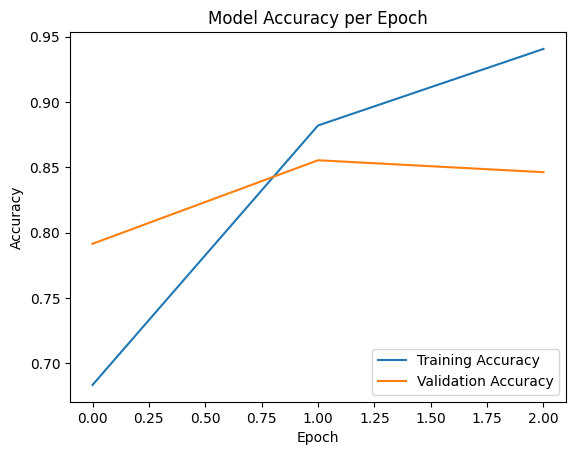

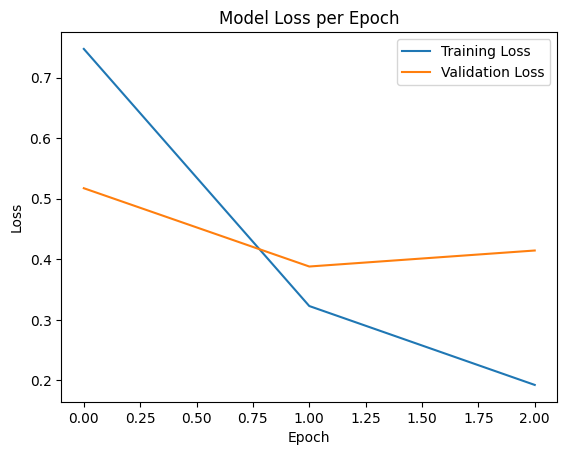

In [40]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [38]:
# Prediksi emosi pada teks baru
new_texts = ["why this is happening to me", "I am so happy today", "im not sad, but happy"]
new_inputs = tokenizer(new_texts, return_tensors="tf", padding=True, truncation=True, max_length=128)

predictions = model.predict(new_inputs['input_ids'])
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

print(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
['sad' 'happy' 'sad']
